# Assignment 1

The goal of this assignment is to supply you with the **building blocks** of **neural networks** (NNs). In this notebook, we will cover the main aspects of NNs, such as **Backpropagation** and **Optimization Methods**. All mathematical operations should be implemented in **NumPy** only. 

The assignmnent consist of two parts:
* *Part one: Blocks* - the place where the main **building blocks** of the NNs are implemented by you
* *Part two: Experiments* - a playground to train the models

### Note
Some of the concepts below have not (yet) been discussed during the lecture. These will be discussed further during the next lectures. 

## Table of contents


* [0. Before you begin](#0.-Before-you-begin)

Part one: Blocks

* [1. Backpropagation](#1.-Backpropagation)   (mandatory)
* [2. Dense layer](#2.-Dense-layer)   (mandatory)
* [3. ReLU nonlinearity](#3.-ReLU-nonlinearity)   (mandatory)
* [4. Sequential model](#4.-Sequential-model)
* [5. Loss](#5.-Loss)   (mandatory)
* [6. $L_2$ Regularization](#6.-$L_2$-Regularization)   (mandatory)
* [7. Optimizer](#7.-Optimizer)
* [8. Advanced blocks](#8.-Advanced-blocks)
    * [8.1 Dropout](#8.1-Dropout)
    * [8.2 MSE Loss](#8.2-MSE-Loss)
    
Part two: Experiments

* [9. Circles Classification Task](#9.-Circles-Classification-Task)
* [10. Digits Classification Task](#10.-Digits-Classification-Task)

# 0. Before you begin

To check whether the code you've written is correct, we'll use **automark**. For this, we created for each of you an account with the username being your student number. 

In [73]:
import automark as am

# fill in you student number as your username
username = '12328537'

# to check your progress, you can run this function
am.get_progress(username)

---------------------------------------------
| Rafael Velloso Pierre                     |
| rafael.pierre@gmail.com                   |
---------------------------------------------
| [MAN] dense_forward      | completed      |
| [MAN] dense_grad_W       | completed      |
| [MAN] dense_grad_b       | completed      |
| [MAN] dense_grad_input   | completed      |
| [MAN] hinge_forward      | completed      |
| [MAN] hinge_grad_input   | completed      |
| [MAN] l2_regularizer     | completed      |
| [MAN] relu_forward       | completed      |
| [MAN] relu_grad_input    | completed      |
| [OPT] dropout_forward    | completed      |
| [OPT] dropout_grad_input | completed      |
| [OPT] mse_forward        | not attempted  |
| [OPT] mse_grad_input     | not attempted  |
---------------------------------------------


So far all your tests are 'not attempted'. At the end of this notebook you'll need to have completed all except 5 tests. The other five will be for next week. At the end of this notebook the output of `am.get_progress(username)` should match the example below.

```
---------------------------------------------
| Your name / student number                |
| your_email@your_domain.whatever           |
---------------------------------------------
| box_blur                 | not attempted  |
| conv_matrix              | not attempted  |
| dense_forward            | completed      |
| dense_grad_W             | completed      |
| dense_grad_b             | completed      |
| dense_grad_input         | completed      |
| dropout_forward          | completed      |
| dropout_grad_input       | completed      |
| flatten_forward          | not attempted  |
| flatten_grad_input       | not attempted  |
| hinge_forward            | completed      |
| hinge_grad_input         | completed      |
| l2_regularizer           | completed      |
| maxpool_forward          | not attempted  |
| mse_forward              | completed      |
| mse_grad_input           | completed      |
| relu_forward             | completed      |
| relu_grad_input          | completed      |
---------------------------------------------
```

Next, we'll import the numpy library:

In [6]:
from __future__ import print_function, absolute_import, division #You don't need to know what this is. 
import numpy as np #this imports numpy, which is used for vector- and matrix calculations

This paragraph is optional and **solely informational**. 

This notebook makes use of **classes** and their **instances** that we have already implemented for you. It allows us to write less code and make it more readable. If you are interested in it, here are some useful links:
* The official [documentation](https://docs.python.org/3/tutorial/classes.html) 
* Video by *sentdex*: [Object Oriented Programming Introduction](https://www.youtube.com/watch?v=ekA6hvk-8H8)
* Antipatterns in OOP: [Stop Writing Classes](https://www.youtube.com/watch?v=o9pEzgHorH0)

The interface of the current blocks is mostly inspired by **[Torch](http://torch.ch) / [PyTorch](http://pytorch.org)**. You can also take a look at the first implementation of [Keras](https://github.com/fchollet/keras/tree/37a1db225420851cc668600c49697d9a2057f098)

# Part one: Blocks

# 1. Backpropagation

Neural networks consist of several layers. Each layer is a function of several parameters that we call weights: $h = f(x, w)$ where $h$ is the layer, $x$ is a vector of inputs and w is a vector of weights. 
In the neural network, the output of one layer is the input for the next layer. This means we can chain the different functions. The whole neural network $F$ then becomes a composition of different functions. 
$$
F = f_k \circ f_{k-1} \circ \dots \ f_1\\
h_1 = f_1(x, w_1)\\
h_2 = f_2(h_1, w_2)\\
\dots \\
\dot{y} = f_k(h_{k-1}, w_k)
$$
In the above functions, $w_1$ and $w_2$ are different **weight vectors** that apply to the different layers $h_1$ and $h_2$. The weights of a neural network basically determine the effect certain outputs have on the next layer. (Please note: When searching for these terms on the internet, be aware that **weights** are sometimes called **parameters**, and $w$ is sometimes denoted as $\theta$.) 


At the end of every neural network, there is a loss function. A loss function calculates for the performance of the Neural Network. The calculation of this score depends on the task at hand. For classification tasks the loss function would calculate the difference between prediction and the correct value. In this case the function is a summation of this difference for each data point. Calculating this difference can, again, be done in different ways. One example that we have discussed in class is the squared-loss for linear regression. (Here, the difference between predicted and correct classification is squared so positive and negative differences don't cancel eachother.) 
$$\mathcal{L} = \tfrac{1}{2}\sum_{n = 1}^N (y_n - \dot{y}_n)^2$$
Here, $n$ denotes the different datapoints, $y_n$ and $\dot{y}$ represent the correct and the predicted value for that data point respectively. 



The smaller the outcome of this loss function, the better the Neural Network predicts the data. Therefore, we concentrate on **minimizing the loss function** as a means for **training** the neural network. 


Training is done with [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). Another word for **gradient** is **derivative**. We use derivatives to update the weights of the neural network to make better predictions. 
The weights of the $k$-th layer are updated according to the following scheme:
$$
w_k \leftarrow w_k - \gamma \frac{\partial \mathcal{L}}{\partial w_k} 
$$
* $\partial f(x)/\partial x$ means the partial derivative of $f(x)$ with respect to $x$. On the internet, derivatives are sometimes written as $f'(x)$, $df/dx$, $\Delta f/x$ or $\nabla f/x$. (Some of these notations have slightly different meanings, but you can ignore that for now.) 
* Hyperparameter $\gamma$ is called the *learning rate* (You'll learn more about hyperparameters later. For now, the only thing you'll have to know is that the value of a hyperparameter is set by you.) 
* Note that $k$ denotes a layer and $n$ denotes a data point.


The computation of $\partial \mathcal{L}/\partial w_k$ is done using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule):
$$
\frac{\partial \mathcal{L}}{\partial w_k} = 
\frac{\partial \mathcal{L}}{\partial h_k}
\frac{\partial h_k}{\partial w_k} = 
\frac{\partial \mathcal{L}}{\partial h_{k+1}}
\frac{\partial h_{k+1}}{\partial h_k}
\frac{\partial h_k}{\partial w_k} = \dots
$$


Therefore, for each layer, we can calculate the following expressions: 
* $h_k = f_k(h_{k-1}, w_k)$ - the forward pass
* $\partial h_{k}/\partial h_{k-1}$ - the partial derivative of the output with respect to the input
* $\partial h_{k}/\partial w_k$ - the partial derivative of the output with respect to the parameters


This whole process of updating weights by calculating the gradient is called [Backpropagation](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf). Click [here](https://www.youtube.com/watch?v=Ilg3gGewQ5U) for a pretty good video explaining backpropagation. 

# 2. Dense layer
A dense Layer is the basic layer of a neural network. (Other terms for dense layer are fully-connected layer and multiplicative layer.) A dense layer transforms an input matrix of size `(n_objects, d_in)` to a matrix of size `(n_objects, d_out)` (where d stands for dimensions) by performing the following operation:
$$
H = XW + b
$$
Here $H$ represents the function of the dense layer, $X$ is the input matrix, $W$ is the weight matrix for this layer and $b$ is the bias. The bias $b$ is a vector. 

A more detailed version of this function is: 
$$
H_{k,n} = \sum\limits_{i=1}^{d_{in}} X_{n,i}W_{i,k} + b_k
$$
where $n$ denotes again a single data object and $k$ the $k^{th}$ layer.

**Example**: 

You have a neural network of just 1 layer. The inputs are points in a 3D space and you want to classify this point as either $-1$ or $1$. 
You have $75$ objects in your training set. 

Therefore, $X$ has shape $75 \times 3$. $H$ has shape $75 \times 1$. Weight $W$ of the layer has shape $3 \times 1$. 

Using the input for a layer and producing its output is called a forward pass. Here, you'll implement the forward pass:  
$$
H = XW + b
$$

In [7]:
def dense_forward(x_input, W, b):
    """Perform the mapping of the input
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the output of a dense layer 
        np.array of size `(n_objects, b_out)`
    """
    
    output = np.dot(x_input, W) + b
    
    #################
    ### YOUR CODE ###
    #################
    return output

Let's check your first function. We set the matrices $X, W, b$:
$$
X = \begin{bmatrix}
1 & -1 \\
-1 & 0 \\
1 & 1 \\
\end{bmatrix} \quad
W = \begin{bmatrix}
4 \\
2 \\
\end{bmatrix} \quad
b = \begin{bmatrix}
3 \\
\end{bmatrix}
$$

And then compute 
$$
XW = \begin{bmatrix}
1 & -1 \\
-1 & 0 \\
1 & 1 \\
\end{bmatrix}
\begin{bmatrix}
4 \\
2 \\
\end{bmatrix} =
\begin{bmatrix}
2 \\
-4 \\
6 \\
\end{bmatrix} \\
XW + b = 
\begin{bmatrix}
5 \\
-1 \\
9 \\
\end{bmatrix} 
$$

In [8]:
X_test = np.array([[1, -1],
                   [-1, 0],
                   [1, 1]])

W_test = np.array([[4],
                   [2]])

b_test = np.array([3])

h_test =  dense_forward(X_test, W_test, b_test)
print(h_test)

[[ 5]
 [-1]
 [ 9]]


In [9]:
am.test_student_function(username, dense_forward, ['x_input', 'W', 'b'])

Running local tests...
passed
dense_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


Now, you'll implement a backward pass. As decribed above, this is calculated with the gradient. To calculate the gradient, we'll use the chain rule: 
$$
\frac{\partial \mathcal{L}}{\partial X} = 
\frac{\partial \mathcal{L}}{\partial H}
\frac{\partial H}{\partial X}
$$

In [10]:
def dense_grad_input(x_input, grad_output, W, b):
    """Calculate the partial derivative of 
        the loss with respect to the input of the layer
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the dense layer 
            np.array of size `(n_objects, n_out)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the partial derivative of the loss with 
        respect to the input of the layer
        np.array of size `(n_objects, n_in)`
    """
    #################
    ### YOUR CODE ###
    #################
    
    m = x_input.shape[0]
    
    #yhat = dense_forward(x_input, W, b)
    
    grad_input = np.dot(grad_output, W.T)
    
    #grad_input = 1/m * np.sum(np.power(grad_output - W.T, 2))
    
    return grad_input

In [7]:
am.test_student_function(username, dense_grad_input, ['x_input', 'grad_output', 'W', 'b'])

Running local tests...
dense_grad_input successfully passed local tests
Running remote test...


ServerError: your timeout expires in 29 sec.

Now, instead of computing the gradient with respect to the input, we'll calculate the gradient with respect to the weights and to the bias: 
$$
\frac{\partial \mathcal{L}}{\partial W} = 
\frac{\partial \mathcal{L}}{\partial H}
\frac{\partial H}{\partial W} \\
\frac{\partial \mathcal{L}}{\partial b} = 
\frac{\partial \mathcal{L}}{\partial H}
\frac{\partial H}{\partial b} \\
$$

In [11]:
def dense_grad_W(x_input, grad_output, W, b):
    """Calculate the partial derivative of 
        the loss with respect to W parameter of the layer
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the dense layer 
            np.array of size `(n_objects, n_out)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the partial derivative of the loss 
        with respect to W parameter of the layer
        np.array of size `(n_in, n_out)`
    """
    #################
    ### YOUR CODE ###
    #################
    
    grad_W = np.dot(grad_output.T, x_input).T
    
    return grad_W

In [12]:
am.test_student_function(username, dense_grad_W, ['x_input', 'grad_output', 'W', 'b'])

Running local tests...
passed
dense_grad_W successfully passed local tests
Running remote test...


ServerError: your timeout expires in 17 sec.

In [13]:
def dense_grad_b(x_input, grad_output, W, b):
    """Calculate the partial derivative of 
        the loss with respect to b parameter of the layer
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the dense layer 
            np.array of size `(n_objects, n_out)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the partial derivative of the loss 
        with respect to b parameter of the layer
        np.array of size `(n_out,)`
    """
    #################
    ### YOUR CODE ###
    #################
    
    grad_b = np.dot(grad_output.T, np.ones(grad_output.shape[0]))

    
    return grad_b

In [158]:
am.test_student_function(username, dense_grad_b, ['x_input', 'grad_output', 'W', 'b'])

Running local tests...
dense_grad_b successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [143]:
am.get_progress(username)

---------------------------------------------
| Rafael Velloso Pierre                     |
| rafael.pierre@gmail.com                   |
---------------------------------------------
| dense_forward            | completed      |
| dense_grad_W             | completed      |
| dense_grad_b             | completed      |
| dense_grad_input         | completed      |
| dropout_forward          | not attempted  |
| dropout_grad_input       | not attempted  |
| hinge_forward            | not attempted  |
| hinge_grad_input         | not attempted  |
| l2_regularizer           | not attempted  |
| mse_forward              | not attempted  |
| mse_grad_input           | not attempted  |
| relu_forward             | not attempted  |
| relu_grad_input          | not attempted  |
---------------------------------------------


## Dense Layer Class

Here, we define a basic class for the dense layer. You will use this in the Experiments sections below. You don't need to know how this works; we implement it for you, but it is based on the functions you've written above. 

In [14]:
class Layer(object):
    
    def __init__(self):
        self.training_phase = True
        self.output = 0.0
        
    def forward(self, x_input):
        self.output = x_input
        return self.output
    
    def backward(self, x_input, grad_output):
        return grad_output
    
    def get_params(self):
        return []
    
    def get_params_gradients(self):
        return []

In [15]:
class Dense(Layer):
    
    def __init__(self, n_input, n_output):
        super(Dense, self).__init__()
        #Randomly initializing the weights from normal distribution
        self.W = np.random.normal(size=(n_input, n_output))
        self.grad_W = np.zeros_like(self.W)
        #initializing the bias with zero
        self.b = np.zeros(n_output)
        self.grad_b = np.zeros_like(self.b)
      
    def forward(self, x_input):
        self.output = dense_forward(x_input, self.W, self.b)
        return self.output
    
    def backward(self, x_input, grad_output):
        # get gradients of weights
        self.grad_W = dense_grad_W(x_input, grad_output, self.W, self.b)
        self.grad_b = dense_grad_b(x_input, grad_output, self.W, self.b)
        # propagate the gradient backwards
        return dense_grad_input(x_input, grad_output, self.W, self.b)
    
    def get_params(self):
        return [self.W, self.b]

    def get_params_gradients(self):
        return [self.grad_W, self.grad_b]

In [16]:
dense_layer = Dense(2, 1)
x_input = np.random.random((3, 2))
y_output = dense_layer.forward(x_input)
print(x_input)
print(y_output)

[[ 0.67070649  0.61274211]
 [ 0.94351452  0.41469671]
 [ 0.3226412   0.18370555]]
[[ 0.38919566]
 [ 0.47110105]
 [ 0.16825262]]


# 3. ReLU nonlinearity

The dense layer, from previous section, is linear. Combinging several linear (dense) layers is always equivalent to a single dense layer. Here is the mathematically proof for this: 
$$
H_1 = XW_1 + b_1\\
H_2 = H_1W_2 + b_2\\
H_2 = (XW_1 + b_1)W_2 + b_2 = X(W_1W_2) + (b_1W_2 + b_2) = XW^* + b^*
$$


For this reason, we're also going to need non-linear layers. Non-linear layers ($f$ in the following) are mostly element-wise and hold the following:
$$
H_1 = XW_1 + b_1\\
H_2 = f(H_1)W_2 + b_2\\
H_2 = f(XW_1 + b_1)W_2 + b_2 \neq XW^* + b^*
$$

A popular example of a simple non-linear layer is **ReLU** (Rectified Linear Unit). ReLU doesn't have weights that can be optimized like a dense layer.
$$
\text{ReLU}(x) = \max(0, x)
$$

<img src="./src/relu.png" width="500">

**Example**

$$
\text{ReLU} \Big(
\begin{bmatrix}
1 & -0.5 \\
0.3 & 0.1 
\end{bmatrix}
\Big) = 
\begin{bmatrix}
1 & 0 \\
0.3 & 0.1 
\end{bmatrix}
$$

Next, you will implement the forward pass and backward pass (gradient) for ReLU. 

In [17]:
def relu_forward(x_input):
    """relu nonlinearity
    # Arguments
        x_input: np.array of size `(n_objects, n_in)`
    # Output
        the output of relu layer
        np.array of size `(n_objects, n_in)`
    """
    #################
    ### YOUR CODE ###
    #################
    
    output = np.maximum(0,x_input)
    
    return output

In [18]:
#test forward pass for ReLU, see example above
x_input = np.array([[1, -0.5],
                    [0.3, 0.1]])

print(relu_forward(x_input))

[[ 1.   0. ]
 [ 0.3  0.1]]


In [19]:
am.test_student_function(username, relu_forward, ['x_input'])

Running local tests...
passed
relu_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [20]:
def reluDerivative(x):
    x2 = x.copy()
    x2[x<0] = 0
    x2[x>=0] = 1
    return x2

In [21]:
def relu_grad_input(x_input, grad_output):
    """relu nonlinearity gradient. 
        Calculate the partial derivative of the loss 
        with respect to the input of the layer
    # Arguments
        x_input: np.array of size `(n_objects, n_in)`
            grad_output: np.array of size `(n_objects, n_in)`
    # Output
        the partial derivative of the loss 
        with respect to the input of the layer
        np.array of size `(n_objects, n_in)`
    """
    #################
    ### YOUR CODE ###
    #################
    
    print(x_input)
    grad_x = grad_output * reluDerivative(x_input)
    
    print(grad_x)
    
    return grad_x

In [34]:
am.test_student_function(username, relu_grad_input, ['x_input', 'grad_output'])

Running local tests...
[[ 1.2238082   2.22719844]
 [-9.66319414  8.65035235]]
[[-1.88677243  7.51987133]
 [ 0.          1.07042446]]
[[-0.88268129]]
[[ 0.]]
[[-6.1346031  -2.59510617 -8.22704924]
 [-4.31838253 -0.81466713  8.8329697 ]
 [ 1.53694353  2.64362748 -2.21348445]]
[[ 0.         -0.          0.        ]
 [ 0.         -0.         -9.54940731]
 [ 7.67099921 -2.04976709 -0.        ]]
[[-6.31269585 -9.74193992]
 [-2.76200546 -0.35260913]
 [-6.94822173  0.26083029]]
[[-0.          0.        ]
 [ 0.          0.        ]
 [-0.          4.11327082]]
[[-9.46602591 -3.4410245   2.83023168 -8.46839598  1.85133024]
 [ 2.41341894  7.12671238  7.16818908 -3.57088982 -8.931725  ]]
[[-0.          0.         -3.10674752  0.          4.8687553 ]
 [ 0.5053492   8.29951978 -7.15579422  0.         -0.        ]]
[[-5.97489257]
 [ 7.37279149]
 [ 3.00216078]]
[[ 0.        ]
 [-7.41784812]
 [-2.91103144]]
[[ 7.02562443 -8.50472929 -8.74181261  6.22078435]
 [-8.63821053  4.45449081  7.59981392 -7.68010

[[ 2.4700799  -1.45599586  4.20435316 -6.11766255  4.9611179  -5.87719915]
 [-2.1273143  -1.79367954 -8.66691421 -8.43001088  6.67654637 -3.55870331]
 [-5.82958588 -1.06062435 -8.24194307 -1.5959458   8.13428888 -2.39656505]
 [-2.82799554 -6.85155099 -5.5283528  -6.02524205 -9.32477911  6.99781896]
 [-3.95584724  9.16757187  8.22132499 -1.23266086  5.85185386 -8.85835494]]
[[ 1.02778454  0.          9.03535624  0.          7.4473256   0.        ]
 [-0.         -0.          0.          0.          8.85632869 -0.        ]
 [-0.         -0.         -0.          0.         -7.06755176 -0.        ]
 [ 0.         -0.          0.          0.          0.          6.13910502]
 [ 0.          6.42266145  6.20512421 -0.          0.10523917  0.        ]]
Test was successful. Congratulations!


In [22]:
class ReLU(Layer):
        
    def forward(self, x_input):
        self.output = relu_forward(x_input)
        return self.output
    
    def backward(self, x_input, grad_output):
        return relu_grad_input(x_input, grad_output)

# 4. Sequential model
In order to make the work with layers more comfortable, we create `SequentialNN` - a class, which stores all its layers and performs the basic manipulations. Again, this is for the experiments below and you don't need to know how this works. 

In [23]:
class SequentialNN(object):

    def __init__(self):
        self.layers = []
        self.training_phase = True
        
    def set_training_phase(self, is_training=True):
        self.training_phase = is_training
        for layer in self.layers:
            layer.training_phase = is_training
        
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, x_input):
        self.output = x_input
        for layer in self.layers:
            self.output = layer.forward(self.output)
        return self.output
    
    def backward(self, x_input, grad_output):
        inputs = [x_input] + [l.output for l in self.layers[:-1]]
        for input_, layer_ in zip(inputs[::-1], self.layers[::-1]):
            grad_output = layer_.backward(input_, grad_output)
            
    def get_params(self):
        params = []
        for layer in self.layers:
            params.extend(layer.get_params())
        return params
    
    def get_params_gradients(self):
        grads = []
        for layer in self.layers:
            grads.extend(layer.get_params_gradients())
        return grads

Here is the simple neural network. It takes an input of shape `(Any, 10)` and passes it through `Dense(10, 4)`, `ReLU` and `Dense(4, 1)`. The output is a batch of size `(Any, 1)`. 
```
  INPUT
    |
Dense(10, 4)
    |
   ReLU
    |
Dense(4, 1)
    |
  OUTPUT
```

In [24]:
nn = SequentialNN()
nn.add(Dense(10, 4))
nn.add(ReLU())
nn.add(Dense(4, 1))

# 5. Loss

Here we will define the loss functions. Each loss should be able to compute its value and compute its gradient with respect to the input. We have implemented these functions (e.g. forward, backward) for you.  

In [25]:
class Loss(object):
    
    def __init__(self):
        self.output = 0.0
        
    def forward(self, target_pred, target_true):
        return self.output
    
    def backward(self, target_pred, target_true):
        return np.zeros_like(target_pred)

In the previous section, you've seen a loss function for a linear regression. Here, you'll implement another sort of loss function used in classification: the [Hinge](https://en.wikipedia.org/wiki/Hinge_loss) loss function: 
$$ 
\mathcal{L}(Y, \dot{Y}) = \frac{1}{N}\sum\limits_{n=1}^{N}\max(0, 1 - \dot{y}_n \cdot y_n)
$$

* $N$ represents the number of data points
* $\dot{Y}$ and $Y$ are vectors of length $N$. $Y$ represents the true classes for your data points and $\dot{Y}$ represents your prediction of the classes. 
* $\dot{y}_n$ represents the predicted class of the $n$-th object. $\dot{y}_n \in {\rm I\!R}$
* $y_n$ is the real class of this object. $y_n \in \{-1, 1\}$

This loss function is used in the SVM classifier. You will learn more about SVM in the lectures or click [here](https://www.youtube.com/watch?v=Y6RRHw9uN9o) for a helpful video. 

Now, you'll calculate the forward pass for the Hinge loss function. 

In [26]:
def hinge_forward(target_pred, target_true):
    """Compute the value of Hinge loss 
        for a given prediction and the ground truth
    # Arguments
        target_pred: predictions - np.array of size `(n_objects,)`
        target_true: ground truth - np.array of size `(n_objects,)`
    # Output
        the value of Hinge loss 
        for a given prediction and the ground truth
        scalar
    """
    #################
    ### YOUR CODE ###
    #################
    
    n = target_pred.shape[0]
    
    # 1/n + Summation(max(0, 1 - yhatn * yn))
    
    output = 1/n * np.sum(np.maximum(0,(1-np.multiply(target_pred, target_true))))
    
    return output

You can test your forward pass below. Your output should be: `0.875`

In [27]:
#test forward pass for Hinge
target_pred = np.array([2,-5,3,0.5])
target_true = np.array([-1,-1,1,1])
print(hinge_forward(target_pred, target_true))

0.875


In [28]:
am.test_student_function(username, hinge_forward, ['target_pred', 'target_true'])

Running local tests...
passed
hinge_forward successfully passed local tests
Running remote test...


ServerError: your timeout expires in 11 sec.

In [42]:
am.get_progress(username)

---------------------------------------------
| Rafael Velloso Pierre                     |
| rafael.pierre@gmail.com                   |
---------------------------------------------
| dense_forward            | completed      |
| dense_grad_W             | completed      |
| dense_grad_b             | completed      |
| dense_grad_input         | completed      |
| dropout_forward          | not attempted  |
| dropout_grad_input       | not attempted  |
| hinge_forward            | completed      |
| hinge_grad_input         | not attempted  |
| l2_regularizer           | not attempted  |
| mse_forward              | not attempted  |
| mse_grad_input           | not attempted  |
| relu_forward             | completed      |
| relu_grad_input          | completed      |
---------------------------------------------


Now, you should compute the gradient of the Hinge loss function with respect to its input. The output of this backward pass is a vector with the same shape as the input. To calculate the derivative of a vector, calculate the derivatives of its elements. Those derivatives become the elements of the derivative of the vector: 
$$
\frac{\partial \mathcal{L}}{\partial \dot{Y}} = 
\begin{bmatrix}
\frac{\partial \mathcal{L}}{\partial \dot{y}_1} \\ 
\frac{\partial \mathcal{L}}{\partial \dot{y}_2} \\ 
\vdots \\
\frac{\partial \mathcal{L}}{\partial \dot{y}_N} \\ 
\end{bmatrix}
$$

Now, you'll implement the backward pass for the Hinge loss function. 

In [29]:
def hinge_grad_input(target_pred, target_true):
    """Compute the partial derivative 
        of Hinge loss with respect to its input
    # Arguments
        target_pred: predictions - np.array of size `(n_objects,)`
        target_true: ground truth - np.array of size `(n_objects,)`
    # Output
        the partial derivative 
        of Hinge loss with respect to its input
        np.array of size `(n_objects,)`
    """

    #################
    ### YOUR CODE ###
    #################  
    
    # zero if value is less than zero
    # otherwise will be equal to minus y
    
    #margins = np.maximum(0,(1-np.multiply(target_pred, target_true)))
    
    #print(margins)
    #print(target_true)
    
    print((1 - target_pred*target_true))
    print(((1 - target_pred*target_true) > 0))
    
    output = -target_true * ((1 - target_pred*target_true) > 0) * 1/target_pred.shape[0]
    
    print(output)
    
    return output

In [74]:
am.test_student_function(username, hinge_grad_input, ['target_pred', 'target_true'])

Running local tests...
[ 6.14864468  3.45050911  5.36338922 -1.05611548 -0.614324   -8.69399719]
[ True  True  True False False False]
[-0.16666667 -0.16666667 -0.16666667 -0.         -0.         -0.        ]
[-5.60802006 -4.23296925  2.77588773 -0.20515052  1.99376393]
[False False  True False  True]
[-0.  -0.   0.2  0.   0.2]
[ 1.12384246  7.43516643 -4.78633833 -6.99763962]
[ True  True False False]
[-0.25 -0.25  0.   -0.  ]
[-8.63767547 -5.6803021 ]
[False False]
[-0.  0.]
[-7.23726109]
[False]
[ 0.]
[-0.41045006]
[False]
[-0.]
[-1.39330332]
[False]
[ 0.]
[-2.56764485 -4.69207049  1.12866747 -0.72529993]
[False False  True False]
[-0.   -0.   -0.25  0.  ]
[-8.81965224  8.72904613]
[False  True]
[-0.  -0.5]
[ 9.67195796]
[ True]
[-1.]
[ 9.27742895 -4.35489932 -3.92852605  4.25530975 -3.5656916   5.93898275]
[ True False False  True False  True]
[ 0.16666667  0.          0.         -0.16666667  0.          0.16666667]
[ 7.57035092]
[ True]
[ 1.]
[ 9.21439148 -5.05398096 -6.38890341  

[-5.05884047 -2.91657663  1.85600086 -4.76982447  7.38440968]
[False False  True False  True]
[ 0.   0.   0.2  0.  -0.2]
Test was successful. Congratulations!


In [30]:
class Hinge(Loss):
    
    def forward(self, target_pred, target_true):
        self.output = hinge_forward(target_pred, target_true)
        return self.output
    
    def backward(self, target_pred, target_true):
        return hinge_grad_input(target_pred, target_true)

# 6. $L_2$ Regularization

Loss functions update the weights of your model to improve your predictions. We do this by minimizing the loss function. However, up until now this loss function did not take into account the complexity of your model. Here we mean with complexity the number of parameters that your model stores. We do want to take complexity into account because complex models can perform poorly on test data, while performing excellent on train data. 

To penalize the complextity of the model, we introduce a regularizer. You'll learn more about regularizers in the lectures, but the general idea is that we take the values of the weights into account with the loss function. High values for weights are indicators of complexity. 

There are several ways of adding regularization to a model. We will implement [$L_2$ regularization](http://www.deeplearningbook.org/contents/regularization.html) also known as weight decay:

The key idea of $L_2$ regularization is to add an extra term to the loss functions:
$$
\mathcal{L}^* = \mathcal{L} + \frac{\lambda}{2} \|w\|^2_2
$$

The part we added to the loss function is called the regularization function. 
* $\lambda$ is named weight decay. It is a hyperparameter that determines the influence of the regularization to the outcome of the loss function. 
* $\|w\|^2_2$ is the squared [euclidian norm](https://en.wikipedia.org/wiki/Euclidean_distance) where $\|w\|^2_2 = \|w_1\|^2_2 + \|w_2\|^2_2 ... \|w_k\|^2_2$. 
This function in more detail becomes:

$$
\mathcal{L}^* = \mathcal{L} + \frac{\lambda}{2} \sum\limits_{m=1}^k \|w_m\|^2_2
$$

Because we use a different loss function, the updating of the weights is also slightly changed: 

$$
w_m \leftarrow w_m - \gamma \frac{\partial \mathcal{L}^*}{\partial w_m}\\
\frac{\partial \mathcal{L}^*}{\partial w_m} = \frac{\partial \mathcal{L}}{\partial w_m} + \lambda w_m\\
w_m \leftarrow w_m - \gamma \frac{\partial \mathcal{L}}{\partial w_m} - \lambda w_m
$$

Here, you'll implement the computation of $L_2$: 
$$
L_2(\lambda, [w_1, w_2, \dots, w_k]) = \frac{\lambda}{2} \sum\limits_{m=1}^k \|w_m\|^2_2
$$ 

In [31]:
def l2_regularizer(weight_decay, weights):
    """Compute the L2 regularization term
    # Arguments
        weight_decay: float
        weights: list of arrays of different shapes
    # Output
        sum of the L2 norms of the input weights
        scalar
    """
    
    #################
    ### YOUR CODE ###
    #################
    
    output = weight_decay/2 * np.power((np.linalg.norm(weights)), 2)
    
    return output

You can test your forward pass below. Your output should be: `108.25`

In [32]:
#test the L2 regularizer
weight_decay = 2
weights = np.array([5,3,7,5,0.5])
print(l2_regularizer(weight_decay, weights))

108.25


In [82]:
am.test_student_function(username, l2_regularizer, ['weight_decay', 'weights'])

Running local tests...
l2_regularizer successfully passed local tests
Running remote test...
Test was successful. Congratulations!


# 7. Optimizer

We implement the optimizer to perform the updates of the weights. Here we have implemented two classes that you will need in the Experiments section.   

In [33]:
class Optimizer(object):
    '''
    This is a basic class. 
    All other optimizers will inherit it
    '''
    def __init__(self, model, lr=0.01, weight_decay=0.0):
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        
    def update_params(self):
        pass


class SGD(Optimizer):
    '''
    Stochastic gradient descent optimizer
    https://en.wikipedia.org/wiki/Stochastic_gradient_descent
    '''
        
    def update_params(self):
        weights = self.model.get_params()
        grads = self.model.get_params_gradients()
        for w, dw in zip(weights, grads):
            update = self.lr * dw + self.weight_decay * w
            # it writes the result to the previous variable instead of copying
            np.subtract(w, update, out=w) 

# 8. Advanced blocks

This is an optional section. If you liked the process of understanding neural networks by implementing them from scratch, here are several more tasks for you.

## 8.1 Dropout

[Dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) is a method of regularization. It can be interpreted as augmentation method. The key idea is to randomly drop some values of the input to avoid overfitting. Its behaviour is different during training and testing.

![dropout](./src/dropout.png)

First of all, you should implement the method of calculating the binary mask. The binary mask has the same shape as the input. The mask could have the value 0 for the certain element with the probability `drop_rate` and it could have the value 1 with a probability of `1.0 - drop_rate`. 

**Note**, the $p$ from the paper linked above is `1.0 - drop_rate`


In [57]:
def dropout_generate_mask(shape, drop_rate):
    """Generate binary mask 
    # Arguments
        shape: shape of the input array 
            tuple 
        drop_rate: probability of the element 
            to be multiplied by 0
            scalar
    # Output
        binary mask 
    """
    #################
    ### YOUR CODE ###
    #################
    
    mask = None
    
    #mask = np.zeros(shape)
    #mask[mask == 0] = 1 - drop_rate
    
    return mask

Now, implement the above-described operation of mapping.

In [58]:
def dropout_forward(x_input, mask, drop_rate, training_phase):
    """Perform the mapping of the input
    # Arguments
        x_input: input of the layer 
            np.array of size `(n_objects, d_in)`
        mask: binary mask
            np.array of size `(n_objects, d_in)`
        drop_rate: probability of the element to be multiplied by 0
            scalar
        training_phase: bool either `True` - training, or `False` - testing
    # Output
        the output of the dropout layer 
        np.array of size `(n_objects, d_in)`
    """
    #################
    ### YOUR CODE ###
    ################# 
    
    if (training_phase):
        output = x_input * mask
        
    else:
        output = x_input * (1 - drop_rate)
    
    return output

In [59]:
am.test_student_function(username, dropout_forward, ['x_input', 'mask', 'drop_rate', 'training_phase'])

Running local tests...
False
mask: [[1]
 [1]
 [1]
 [1]
 [1]
 [1]]
mask * (1-drop_rate): [[ 0.89716138]
 [ 0.89716138]
 [ 0.89716138]
 [ 0.89716138]
 [ 0.89716138]
 [ 0.89716138]]
x_input: [[ 5.2613021 ]
 [-9.32911212]
 [-7.93679757]
 [-3.54690413]
 [-3.70779371]
 [-0.09034737]]
False
mask: [[1 1 1 1 1 1]
 [1 1 1 1 1 0]
 [1 1 1 1 1 1]
 [1 1 1 1 1 0]]
mask * (1-drop_rate): [[ 0.94502965  0.94502965  0.94502965  0.94502965  0.94502965  0.94502965]
 [ 0.94502965  0.94502965  0.94502965  0.94502965  0.94502965  0.        ]
 [ 0.94502965  0.94502965  0.94502965  0.94502965  0.94502965  0.94502965]
 [ 0.94502965  0.94502965  0.94502965  0.94502965  0.94502965  0.        ]]
x_input: [[-5.94352404  2.15131468 -5.07874828  2.87692798  4.12535273 -6.01515909]
 [ 1.69756813  5.09485155  1.51105551 -3.24479003  8.7277919  -0.93125818]
 [-2.03557528  7.38047805 -5.91896992 -1.96413343  5.32681431  3.3247982 ]
 [ 8.86285572 -5.40383548 -1.74782085 -1.07356512 -9.85769014 -2.49464965]]
True
mask: [[0 

False
mask: [[0 1 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 1]]
mask * (1-drop_rate): [[ 0.          0.12517048  0.          0.          0.12517048]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.12517048  0.          0.          0.12517048]]
x_input: [[ 8.76298352 -5.05540529 -2.57062032 -0.80272914 -2.37771272]
 [ 8.4552056   1.72118532 -1.54706414 -5.54017054  4.49562263]
 [ 4.36456319 -9.64352058  4.54483511  2.9979814  -1.07621569]
 [-0.11303877 -4.84251104 -1.17989278  2.43024395 -5.92819052]]
Test was successful. Congratulations!


And, as usual, implement the calculation of the partial derivative of the loss function with respect to the input of a layer. 

In [71]:
def dropout_grad_input(x_input, grad_output, mask):
    """Calculate the partial derivative of 
        the loss with respect to the input of the layer
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the dropout layer 
            np.array of size `(n_objects, n_in)`
        mask: binary mask
            np.array of size `(n_objects, n_in)`
    # Output
        the partial derivative of the loss with 
        respect to the input of the layer
        np.array of size `(n_objects, n_in)`
    """
    #################
    ### YOUR CODE ###
    #################
    print(mask)
    
    print(x_input)
    
    print(grad_output)
    
    grad_input = grad_output * mask
    
    return grad_input

In [72]:
am.test_student_function(username, dropout_grad_input, ['x_input', 'grad_output', 'mask'])

Running local tests...
[[0 1]
 [0 1]
 [1 1]]
[[ 4.46867309 -2.246445  ]
 [-9.87843283  8.40137601]
 [ 8.07579107 -3.61408141]]
[[ 9.70257116  1.619105  ]
 [ 1.31645155 -9.62242213]
 [-2.81160126  5.09689001]]
[[0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[-3.13666183  0.89403644  8.49467789  8.61726685  6.27577018  7.00977425]
 [ 6.12380505 -3.07743709 -9.15096467 -3.79640487 -7.38217839  5.05804238]
 [ 4.89901846  8.97842781  2.10323205  8.46090826  3.05025641  1.73570409]
 [-5.02087323 -2.4263051  -0.29515989  6.84702831 -8.83979083  8.8051411 ]
 [-4.60691196 -5.96846647 -7.95966888  3.75698165  9.63177286 -0.41093937]]
[[-3.50952167 -5.02389597 -2.88295282 -8.32800161  0.85257742  2.38400813]
 [ 6.25771358  4.54641375 -9.12829846  4.04902282  7.43576026  6.2457818 ]
 [ 0.79819654 -3.66367943  2.01401837 -0.21295424  0.78941117 -7.94160767]
 [ 0.76964708  7.48637267  4.82226296  3.55290356  7.26484044  1.67653154]
 [ 3.29341415 -2.03324151 -1.24905384  

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]
[[-6.94660194 -6.8957683  -2.76113366  7.35823297 -2.93621557]
 [-9.56154302  3.55177619  3.22135192  6.50889257  2.8232639 ]
 [ 8.82495844  3.0423228  -4.45499096  0.33017539  1.9109673 ]
 [-3.76819324 -1.71467732  0.01035966 -5.44429752 -3.2562447 ]]
[[-1.7489796   2.62152712 -1.62663862 -2.01776951 -0.40001391]
 [-6.72133419  6.12638446  2.90752915  6.67129919 -5.09290392]
 [ 9.71550732 -2.22703651 -6.21292731 -2.2836569  -3.67894512]
 [ 3.66871674 -3.03728395 -2.73102368  1.5692468  -9.86365504]]
Test was successful. Congratulations!


In [ ]:
class Dropout(Layer):
    
    def __init__(self, drop_rate):
        super(Dropout, self).__init__()
        self.drop_rate = drop_rate
        self.mask = 1.0
        
    def forward(self, x_input):
        if self.training_phase:
            self.mask = dropout_generate_mask(x_input.shape, self.drop_rate)
        self.output = dropout_forward(x_input, self.mask, 
                                      self.drop_rate, self.training_phase)
        return self.output
    
    def backward(self, x_input, grad_output):
        grad_input = dropout_grad_input(x_input, grad_output, self.mask)
        return grad_input

## 8.2 MSE Loss
MSE (Mean Squared Error) is a popular loss for the regression tasks.

$$
\mathcal{L}(Y, \dot{Y}) = \frac{1}{2N}\sum\limits_{n=1}^N(y_n - \dot{y}_n)^2
$$

* $N$ - number of objects
* $\dot{Y}$ and $Y$ are the vectors of length $N$. 
* $\dot{y}_n$ is the predicted target value of the $n$-th object. $\dot{y}_n \in {\rm I\!R}$
* $y_n$ is the real target value of the $n$-th object. $y_n \in {\rm I\!R}$
* This loss function is used to train regressors.

Let's implement the calculation of the loss.

In [92]:
def mse_forward(target_pred, target_true):
    """Compute the value of MSE loss
        for a given prediction and the ground truth
    # Arguments
        target_pred: predictions - np.array of size `(n_objects,)`
        target_true: ground truth - np.array of size `(n_objects,)`
    # Output
        the value of MSE loss 
        for a given prediction and the ground truth
        scalar
    """
    #################
    ### YOUR CODE ###
    ################# 
    
    N = target_pred.shape[0]
    
    print(N)
    
    output = (1/(2*N)) * np.sum(np.power((target_true - target_pred), 2))
    
    return output

In [93]:
am.test_student_function(username, mse_forward, ['target_pred', 'target_true'])

Running local tests...
5
1
2
1
6
2
1
2
6
3
2
1
6
3
5
4
5
3
4
1
6
1
3
4
2
6
6
2
3
2
2
5
3
2
2
2
1
5
3
3
5
5
3
3
2
4
2
4
2
6
6
1
5
2
4
3
1
6
4
2
2
5
3
4
1
1
1
4
6
6
5
5
2
4
1
5
2
5
4
1
2
2
4
2
1
3
4
2
5
1
5
4
2
5
6
5
6
6
3
4
passed
mse_forward successfully passed local tests
Running remote test...
3
Test was successful. Congratulations!


Now you should compute the gradient of the loss function with respect to its input. 

In [94]:
def mse_grad_input(target_pred, target_true):
    """Compute the partial derivative 
        of MSE loss with respect to its input
    # Arguments
        target_pred: predictions - np.array of size `(n_objects,)`
        target_true: ground truth - np.array of size `(n_objects,)`
    # Output
        the partial derivative 
        of MSE loss with respect to its input
        np.array of size `(n_objects,)`
    """
    #################
    ### YOUR CODE ###
    #################
    
    N = target_pred.shape[0]
    
    grad_input = (1/N) * (target_true - target_pred) * -np.ones(N)
    
    return grad_input

In [95]:
am.test_student_function(username, mse_grad_input, ['target_pred', 'target_true'])

Running local tests...
passed
mse_grad_input successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [96]:
class MSE(Loss):
    
    def forward(self, target_pred, target_true):
        self.output = mse_forward(target_pred, target_true)
        return self.output
    
    def backward(self, target_pred, target_true):
        return mse_grad_input(target_pred, target_true)

Let's check the progress one more time

In [97]:
am.get_progress(username)

---------------------------------------------
| Rafael Velloso Pierre                     |
| rafael.pierre@gmail.com                   |
---------------------------------------------
| [MAN] dense_forward      | completed      |
| [MAN] dense_grad_W       | completed      |
| [MAN] dense_grad_b       | completed      |
| [MAN] dense_grad_input   | completed      |
| [MAN] hinge_forward      | completed      |
| [MAN] hinge_grad_input   | completed      |
| [MAN] l2_regularizer     | completed      |
| [MAN] relu_forward       | completed      |
| [MAN] relu_grad_input    | completed      |
| [OPT] dropout_forward    | completed      |
| [OPT] dropout_grad_input | completed      |
| [OPT] mse_forward        | completed      |
| [OPT] mse_grad_input     | completed      |
---------------------------------------------


# Part two: Experiments

Seems like you've already implemented all the building blocks of the Neural Network. Now we will conduct several experiments.

**Note:** These experiments will not be evaluated.

## 9. Circles Classification Task

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 

In this first task we created a dataset of 2 circles made out of dots from 2 different formulas. It is your task to predict for each dot which circle it belongs to. 

The main purpose of this task is to understand the **importance of network design and parameter tuning (number of layers, number of hidden units, etc.)**. At first, we will generate and visualize the data in following cell.

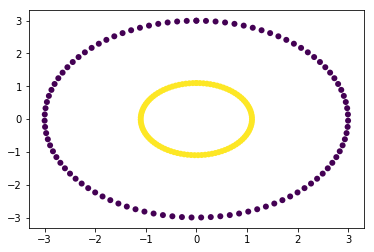

In [99]:
# Generate some data
N = 100
phi = np.linspace(0.0, np.pi * 2, 100)
X1 = 1.1 * np.array([np.sin(phi), np.cos(phi)])
X2 = 3.0 * np.array([np.sin(phi), np.cos(phi)])

Y = np.concatenate([np.ones(N), -1.0 * np.ones(N)]).reshape((-1, 1))

X = np.hstack([X1,X2]).T
plt.scatter(X[:,0], X[:,1], c=Y.ravel(), edgecolors= 'none')

As you have already written the code blocks, we will just call those functions and will train the network to classify the two circles. 

For this task we have provided the code for training and testing of the network in following blocks. Students are asked to design the network with different configurations  and observe the outputs.
* **Single Layer Neural Network**
* **Multiple Layer Neural Network**
* **Different number of Hidden units**
* **With and without activation function**

In [103]:
##Training the network ##
model = SequentialNN()

###YOUR CODE FOR DESIGNING THE NETWORK ###
# model.add(...)
# model.add(...)

loss = Hinge()
weight_decay = 0.01
sgd = SGD(model, lr=0.1, weight_decay=weight_decay)
epochs = 100 # Number of times to iterate over all data objects

model.set_training_phase(True)

for i in range(100):
    # get the predictions
    y_pred = model.forward(X)
    
    # compute the loss value + L_2 term
    loss_value = loss.forward(y_pred, Y) + l2_regularizer(weight_decay, model.get_params())
    
    # log the current loss value
    print('Step: {}, \tLoss = {:.2f}'.format(i+1, loss_value))
    
    # get the gradient of the loss functions
    loss_grad = loss.backward(y_pred, Y)

    # backprop the gradients
    model.backward(X, loss_grad)
    
    # perform the updates
    sgd.update_params()

Step: 1, 	Loss = 2.52
[[  1.00000000e+00  -1.00000000e-01]
 [  9.30233688e-01  -9.77853441e-02]
 [  8.60748301e-01  -9.11502941e-02]
 [  7.91823631e-01  -8.01215670e-02]
 [  7.23737214e-01  -6.47435715e-02]
 [  6.56763210e-01  -4.50782295e-02]
 [  5.91171299e-01  -2.12047263e-02]
 [  5.27225597e-01   6.78080788e-03]
 [  4.65183590e-01   3.87656852e-02]
 [  4.05295101e-01   7.46211139e-02]
 [  3.47801278e-01   1.14202717e-01]
 [  2.92933629e-01   1.57351113e-01]
 [  2.40913087e-01   2.03892558e-01]
 [  1.91949120e-01   2.53639647e-01]
 [  1.46238889e-01   3.06392066e-01]
 [  1.03966453e-01   3.61937399e-01]
 [  6.53020271e-02   4.20051986e-01]
 [  3.04013002e-02   4.80501818e-01]
 [ -5.95194890e-04   5.43043486e-01]
 [ -2.75626463e-02   6.07425156e-01]
 [ -5.03924656e-02   6.73387587e-01]
 [ -6.89927252e-02   7.40665171e-01]
 [ -8.32885283e-02   8.08987005e-01]
 [ -9.32223109e-02   8.78077980e-01]
 [ -9.87540731e-02   9.47659893e-01]
 [ -9.98615404e-02   1.01745256e+00]
 [ -9.65402535e-

[[-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.00

[[  1.00000000e+00  -1.00000000e-01]
 [  9.30233688e-01  -9.77853441e-02]
 [  8.60748301e-01  -9.11502941e-02]
 [  7.91823631e-01  -8.01215670e-02]
 [  7.23737214e-01  -6.47435715e-02]
 [  6.56763210e-01  -4.50782295e-02]
 [  5.91171299e-01  -2.12047263e-02]
 [  5.27225597e-01   6.78080788e-03]
 [  4.65183590e-01   3.87656852e-02]
 [  4.05295101e-01   7.46211139e-02]
 [  3.47801278e-01   1.14202717e-01]
 [  2.92933629e-01   1.57351113e-01]
 [  2.40913087e-01   2.03892558e-01]
 [  1.91949120e-01   2.53639647e-01]
 [  1.46238889e-01   3.06392066e-01]
 [  1.03966453e-01   3.61937399e-01]
 [  6.53020271e-02   4.20051986e-01]
 [  3.04013002e-02   4.80501818e-01]
 [ -5.95194890e-04   5.43043486e-01]
 [ -2.75626463e-02   6.07425156e-01]
 [ -5.03924656e-02   6.73387587e-01]
 [ -6.89927252e-02   7.40665171e-01]
 [ -8.32885283e-02   8.08987005e-01]
 [ -9.32223109e-02   8.78077980e-01]
 [ -9.87540731e-02   9.47659893e-01]
 [ -9.98615404e-02   1.01745256e+00]
 [ -9.65402535e-02   1.08717495e+00]
 

[[-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.   ]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.    -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.005]
 [-0.005 -0.00

[[  1.00000000e+00  -1.00000000e-01]
 [  9.30233688e-01  -9.77853441e-02]
 [  8.60748301e-01  -9.11502941e-02]
 [  7.91823631e-01  -8.01215670e-02]
 [  7.23737214e-01  -6.47435715e-02]
 [  6.56763210e-01  -4.50782295e-02]
 [  5.91171299e-01  -2.12047263e-02]
 [  5.27225597e-01   6.78080788e-03]
 [  4.65183590e-01   3.87656852e-02]
 [  4.05295101e-01   7.46211139e-02]
 [  3.47801278e-01   1.14202717e-01]
 [  2.92933629e-01   1.57351113e-01]
 [  2.40913087e-01   2.03892558e-01]
 [  1.91949120e-01   2.53639647e-01]
 [  1.46238889e-01   3.06392066e-01]
 [  1.03966453e-01   3.61937399e-01]
 [  6.53020271e-02   4.20051986e-01]
 [  3.04013002e-02   4.80501818e-01]
 [ -5.95194890e-04   5.43043486e-01]
 [ -2.75626463e-02   6.07425156e-01]
 [ -5.03924656e-02   6.73387587e-01]
 [ -6.89927252e-02   7.40665171e-01]
 [ -8.32885283e-02   8.08987005e-01]
 [ -9.32223109e-02   8.78077980e-01]
 [ -9.87540731e-02   9.47659893e-01]
 [ -9.98615404e-02   1.01745256e+00]
 [ -9.65402535e-02   1.08717495e+00]
 

Step: 61, 	Loss = 2.52
[[  1.00000000e+00  -1.00000000e-01]
 [  9.30233688e-01  -9.77853441e-02]
 [  8.60748301e-01  -9.11502941e-02]
 [  7.91823631e-01  -8.01215670e-02]
 [  7.23737214e-01  -6.47435715e-02]
 [  6.56763210e-01  -4.50782295e-02]
 [  5.91171299e-01  -2.12047263e-02]
 [  5.27225597e-01   6.78080788e-03]
 [  4.65183590e-01   3.87656852e-02]
 [  4.05295101e-01   7.46211139e-02]
 [  3.47801278e-01   1.14202717e-01]
 [  2.92933629e-01   1.57351113e-01]
 [  2.40913087e-01   2.03892558e-01]
 [  1.91949120e-01   2.53639647e-01]
 [  1.46238889e-01   3.06392066e-01]
 [  1.03966453e-01   3.61937399e-01]
 [  6.53020271e-02   4.20051986e-01]
 [  3.04013002e-02   4.80501818e-01]
 [ -5.95194890e-04   5.43043486e-01]
 [ -2.75626463e-02   6.07425156e-01]
 [ -5.03924656e-02   6.73387587e-01]
 [ -6.89927252e-02   7.40665171e-01]
 [ -8.32885283e-02   8.08987005e-01]
 [ -9.32223109e-02   8.78077980e-01]
 [ -9.87540731e-02   9.47659893e-01]
 [ -9.98615404e-02   1.01745256e+00]
 [ -9.65402535e

Step: 73, 	Loss = 2.52
[[  1.00000000e+00  -1.00000000e-01]
 [  9.30233688e-01  -9.77853441e-02]
 [  8.60748301e-01  -9.11502941e-02]
 [  7.91823631e-01  -8.01215670e-02]
 [  7.23737214e-01  -6.47435715e-02]
 [  6.56763210e-01  -4.50782295e-02]
 [  5.91171299e-01  -2.12047263e-02]
 [  5.27225597e-01   6.78080788e-03]
 [  4.65183590e-01   3.87656852e-02]
 [  4.05295101e-01   7.46211139e-02]
 [  3.47801278e-01   1.14202717e-01]
 [  2.92933629e-01   1.57351113e-01]
 [  2.40913087e-01   2.03892558e-01]
 [  1.91949120e-01   2.53639647e-01]
 [  1.46238889e-01   3.06392066e-01]
 [  1.03966453e-01   3.61937399e-01]
 [  6.53020271e-02   4.20051986e-01]
 [  3.04013002e-02   4.80501818e-01]
 [ -5.95194890e-04   5.43043486e-01]
 [ -2.75626463e-02   6.07425156e-01]
 [ -5.03924656e-02   6.73387587e-01]
 [ -6.89927252e-02   7.40665171e-01]
 [ -8.32885283e-02   8.08987005e-01]
 [ -9.32223109e-02   8.78077980e-01]
 [ -9.87540731e-02   9.47659893e-01]
 [ -9.98615404e-02   1.01745256e+00]
 [ -9.65402535e

[[  1.00000000e+00  -1.00000000e-01]
 [  9.30233688e-01  -9.77853441e-02]
 [  8.60748301e-01  -9.11502941e-02]
 [  7.91823631e-01  -8.01215670e-02]
 [  7.23737214e-01  -6.47435715e-02]
 [  6.56763210e-01  -4.50782295e-02]
 [  5.91171299e-01  -2.12047263e-02]
 [  5.27225597e-01   6.78080788e-03]
 [  4.65183590e-01   3.87656852e-02]
 [  4.05295101e-01   7.46211139e-02]
 [  3.47801278e-01   1.14202717e-01]
 [  2.92933629e-01   1.57351113e-01]
 [  2.40913087e-01   2.03892558e-01]
 [  1.91949120e-01   2.53639647e-01]
 [  1.46238889e-01   3.06392066e-01]
 [  1.03966453e-01   3.61937399e-01]
 [  6.53020271e-02   4.20051986e-01]
 [  3.04013002e-02   4.80501818e-01]
 [ -5.95194890e-04   5.43043486e-01]
 [ -2.75626463e-02   6.07425156e-01]
 [ -5.03924656e-02   6.73387587e-01]
 [ -6.89927252e-02   7.40665171e-01]
 [ -8.32885283e-02   8.08987005e-01]
 [ -9.32223109e-02   8.78077980e-01]
 [ -9.87540731e-02   9.47659893e-01]
 [ -9.98615404e-02   1.01745256e+00]
 [ -9.65402535e-02   1.08717495e+00]
 

[[  1.00000000e+00  -1.00000000e-01]
 [  9.30233688e-01  -9.77853441e-02]
 [  8.60748301e-01  -9.11502941e-02]
 [  7.91823631e-01  -8.01215670e-02]
 [  7.23737214e-01  -6.47435715e-02]
 [  6.56763210e-01  -4.50782295e-02]
 [  5.91171299e-01  -2.12047263e-02]
 [  5.27225597e-01   6.78080788e-03]
 [  4.65183590e-01   3.87656852e-02]
 [  4.05295101e-01   7.46211139e-02]
 [  3.47801278e-01   1.14202717e-01]
 [  2.92933629e-01   1.57351113e-01]
 [  2.40913087e-01   2.03892558e-01]
 [  1.91949120e-01   2.53639647e-01]
 [  1.46238889e-01   3.06392066e-01]
 [  1.03966453e-01   3.61937399e-01]
 [  6.53020271e-02   4.20051986e-01]
 [  3.04013002e-02   4.80501818e-01]
 [ -5.95194890e-04   5.43043486e-01]
 [ -2.75626463e-02   6.07425156e-01]
 [ -5.03924656e-02   6.73387587e-01]
 [ -6.89927252e-02   7.40665171e-01]
 [ -8.32885283e-02   8.08987005e-01]
 [ -9.32223109e-02   8.78077980e-01]
 [ -9.87540731e-02   9.47659893e-01]
 [ -9.98615404e-02   1.01745256e+00]
 [ -9.65402535e-02   1.08717495e+00]
 

ValueError: Invalid RGBA argument: False

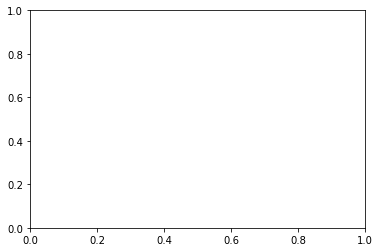

In [104]:
##Testing the network ##
model.set_training_phase(False)
y_pred = model.forward(X) > 0
plt.scatter(X[:,0], X[:,1], c = y_pred.ravel())

# 10. Digits Classification Task

In this task you will implement a neural network for classification of hand written digits. You can use the blocks of code which you implemented in the first part of this assignment for completing this task.

We will use **digits** dataset for this task. This dataset consists of 1797 8x8 images. Further information about the dataset can be found [here](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits). 

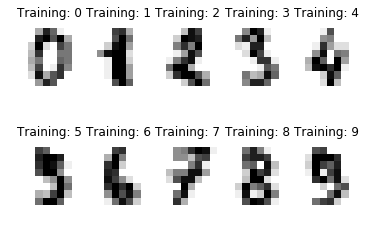

In [105]:
import sklearn.datasets

# We load the dataset
digits = sklearn.datasets.load_digits()

# Here we load up the images and labels and print some examples
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap='gray_r', interpolation='nearest')
    plt.title('Training: {}'.format(label), y=1.1)

Next we will divide the images and labels data into two parts i.e. training data and test data.

In [106]:
n_objects = digits.images.shape[0]
train_test_split = 0.7
train_size = int(n_objects * train_test_split)
indices = np.arange(n_objects)
np.random.shuffle(indices)

train_indices, test_indices = indices[:train_size], indices[train_size:]
train_images, train_targets = digits.images[train_indices], digits.target[train_indices]
test_images, test_targets = digits.images[test_indices], digits.target[test_indices]

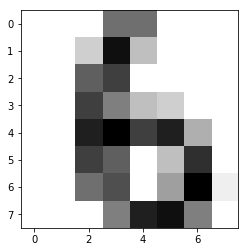

In [107]:
plt.imshow(train_images[0], cmap='gray_r')

The images in the dataset are $8 \times 8$ and each pixels in the image is an integer between ranging from 0 to 16. Before giving the images as input to the neural network we will reshape them to a 1-dimensional vector of 64 features as shown in the figure below.
![in](./src/image_pixel_input.png)

In [108]:
train_images = train_images.reshape((-1, 64))
test_images = test_images.reshape((-1, 64))

train_targets = train_targets.reshape(-1, 1)
test_targets = test_targets.reshape(-1, 1)

The basic units of the neural network are perceptrons. A perceptron consists of a cell with atleast two inputs. The cell takes the inputs multiplied with weights and gives an output after computing the values. The basic diagram of a cell is shown below.
![neuron](./src/neuron.png)
For the image dataset which we will be using in this task the perceptron will have 64 inputs and 64 weights.
![N_weights](./src/weights.png)
As the digits dataset consists of 10 classes (0 to 9), in order to classifiy the images we will need 10 neurons for the prediction of the target class as shown in the image below. Each neuron will give an output and the output from the neuron with the highest value will be selected and that will be the predicted class.
![NN](./src/design.png)
Now, in order to perform classification for images you will use the functions which you implemented before.

In the following lines of code we will train a complete Neural Network by giving the images as input and the labels as targets to the network. At first we will design the network by setting the parameters of the network by calling the *SequentialNN()* function. After that, we will forward propagate the inputs through the network and calculate the loss, the error between the predicted output and the target output. This loss will then be back propagated through the network. Finally the parameters of the network will be updated in the right direction to reduce the error of the prediction.

In [109]:
### YOUR CODE FOR TRAINING THE NETWORK###

#Specify the input size for the network
#specify the output size for the network
#specify the inputs for the network
#specify the outputs for the network
num_input = train_size
num_output = train_
X = train_images
Y = train_targets

model = SequentialNN()
# model.add(...)
# model.add(...)
# etc...

loss = Hinge()
weight_decay = 0.01
sgd = SGD(model, lr=0.01, weight_decay=weight_decay)
model.set_training_phase(True)

for i in range(100):
    # get the predictions
    y_pred = model.forward(X)
    
    # compute the loss value + L_2 term
    loss_value = loss.forward(y_pred, Y) + l2_regularizer(weight_decay, model.get_params())
    
    # log the current loss value
    print('Step: {}, \tLoss = {:.2f}'.format(i+1, loss_value))
    
    # get the gradient of the loss functions
    loss_grad = loss.backward(y_pred, Y)
    # backprop the gradients
    model.backward(X, loss_grad)
    
    # perform the updates
    sgd.update_params()

AttributeError: 'NoneType' object has no attribute 'shape'

After training the network should be tested on test data; images in this task. During the test time unlabeled inputs are given to the network and by using the trained weights from the training cycle of the network the ouput classes for the unlabeled inputs are predicted. The figure below shows the difference between the training and the testing of the network.
![test](./src/Test.PNG)
In the following cell implement the code for testing the network. 

In [ ]:
#Testing the network 
###YOUR CODE FOR TESTING THE NETWORK  ###

For further practice and advanced experiments you can use MNIST dataset for the classification of hand written digits. It is a commonly used image dataset for testing machine learning algorithms. You can load this dataset by using the code from the file *data_utils* in week_1 folder. 

In [ ]:
am.get_progress(username)